# Description

It analyzes how correlation coefficients intersect on different gene pairs. Basically, I take the top gene pairs with the maximum correlation coefficient according to Pearson, Spearman and CCC, and also the equivalent set with the minimum coefficient values, and then compare how these sets intersect each other.

After identifying different intersection sets, I plot some gene pairs to see what's being captured or not by each coefficient.

# Modules

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from upsetplot import plot, from_indicators
from pathlib import Path
from ccc.plots import MyUpSet
from ccc import conf


# Settings

In [2]:
GTEX_TISSUE = "kidney_medulla"
GENE_SEL_STRATEGY = "var_pc_log2"
TOP_N_GENES = "all"

DATA_DIR = Path("/mnt/data/proj_data/ccc-gpu/gene_expr/data/gtex_v8")
SIMILARITY_MATRICES_DIR = DATA_DIR / "similarity_matrices" / TOP_N_GENES


# this specificies the threshold to compare coefficients (see below).
# it basically takes the top Q_DIFF coefficient values for gene pairs
# and compare with the bottom Q_DIFF of the other coefficients
Q_DIFF = 0.30

In [3]:
OUTPUT_DIR = Path("/mnt/data/proj_data/ccc-gpu/results/gene_pair_intersections")
OUTPUT_FIGURE_NAME = "upsetplot_gtex_{GTEX_TISSUE}"
OUTPUT_GENE_PAIR_INTERSECTIONS_NAME = f"gene_pair_intersections-gtex_v8-{GTEX_TISSUE}-{GENE_SEL_STRATEGY}.pkl"

# Create OUTPUT_DIR
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

In [4]:
assert OUTPUT_DIR.exists()
assert SIMILARITY_MATRICES_DIR.exists()

In [5]:
SIMILARITY_MATRIX_FILENAME_TEMPLATE = "gtex_v8_data_{tissue}-{gene_sel_strategy}-{corr_method}.pkl"
INPUT_CORR_FILE_TEMPLATE = SIMILARITY_MATRICES_DIR / SIMILARITY_MATRIX_FILENAME_TEMPLATE
display(INPUT_CORR_FILE_TEMPLATE)

PosixPath('/mnt/data/proj_data/ccc-gpu/gene_expr/data/gtex_v8/similarity_matrices/all/gtex_v8_data_{tissue}-{gene_sel_strategy}-{corr_method}.pkl')

In [6]:
INPUT_CORR_FILE = SIMILARITY_MATRICES_DIR / str(
    INPUT_CORR_FILE_TEMPLATE
).format(
    tissue=GTEX_TISSUE,
    gene_sel_strategy=GENE_SEL_STRATEGY,
    corr_method="all",
)
display(INPUT_CORR_FILE)

assert INPUT_CORR_FILE.exists()

PosixPath('/mnt/data/proj_data/ccc-gpu/gene_expr/data/gtex_v8/similarity_matrices/all/gtex_v8_data_kidney_medulla-var_pc_log2-all.pkl')

# Data

## Correlation

In [7]:
df = pd.read_pickle(INPUT_CORR_FILE)

In [8]:
df.shape

(692459505, 3)

In [9]:
df.head(15)

ccc   pearson  spearman
ENSG00000211592.8  ENSG00000211596.3   1.0  1.000000  1.000000
ENSG00000116218.12 ENSG00000211596.3   1.0  0.130737  0.799805
                   ENSG00000211592.8   1.0  0.145020  0.799805
ENSG00000211893.3  ENSG00000211596.3   1.0  0.951172  1.000000
                   ENSG00000211592.8   1.0  0.955566  1.000000
                   ENSG00000116218.12  1.0  0.429932  0.799805
ENSG00000211594.2  ENSG00000211596.3   1.0  1.000000  0.799805
                   ENSG00000211592.8   1.0  0.999512  0.799805
                   ENSG00000116218.12  1.0  0.116821  0.600098
                   ENSG00000211893.3   1.0  0.946777  0.799805
ENSG00000211597.2  ENSG00000211596.3   1.0  1.000000  1.000000
                   ENSG00000211592.8   1.0  1.000000  1.000000
                   ENSG00000116218.12  1.0  0.129150  0.799805
                   ENSG00000211893.3   1.0  0.950684  1.000000
                   ENSG00000211594.2   1.0  1.000000  0.799805

In [10]:
df.describe()

/home/haoyu/miniforge3/envs/ccc-gpu/lib/python3.10/site-packages/pandas/core/nanops.py:1487: RuntimeWarning: overflow encountered in cast
  return dtype.type(n)
/home/haoyu/miniforge3/envs/ccc-gpu/lib/python3.10/site-packages/numpy/core/_methods.py:49: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)
/home/haoyu/miniforge3/envs/ccc-gpu/lib/python3.10/site-packages/pandas/core/nanops.py:731: RuntimeWarning: invalid value encountered in scalar divide
  the_mean = the_sum / count if count > 0 else np.nan
/home/haoyu/miniforge3/envs/ccc-gpu/lib/python3.10/site-packages/pandas/core/nanops.py:1487: RuntimeWarning: overflow encountered in cast
  return dtype.type(n)
/home/haoyu/miniforge3/envs/ccc-gpu/lib/python3.10/site-packages/numpy/core/_methods.py:49: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)
/home/haoyu/miniforge3/envs/ccc-gpu/lib/python3.10/site-packages/pa

,ccc,pearson,spearman
count,692459505.0,6.924595e+08,6.924595e+08
mean,NaN,NaN,NaN
std,0.0,0.000000e+00,0.000000e+00
min,0.0,0.000000e+00,0.000000e+00
25%,0.0,2.866211e-01,2.583008e-01
50%,0.0,5.302734e-01,3.999023e-01
75%,1.0,7.929688e-01,7.998047e-01
max,1.0,1.000000e+00,1.000000e+00


In [11]:
# Calculate quantiles from 20% to 100% in 20 steps for each correlation method
# This helps understand the distribution of correlation values and identify
# appropriate thresholds for high/low correlation gene pairs
df.apply(lambda x: x.quantile(np.linspace(0.20, 1.0, 20)))

,ccc,pearson,spearman
0.200000,0.000000,0.231201,0.258301
0.242105,0.000000,0.278076,0.258301
0.284211,0.000000,0.324219,0.272217
0.326316,0.000000,0.353271,0.333252
0.368421,0.000000,0.397705,0.399902
0.410526,0.000000,0.440918,0.399902
0.452632,0.000000,0.483887,0.399902
0.494737,0.000000,0.524902,0.399902
0.536842,0.000000,0.566895,0.600098
0.578947,0.000000,0.608887,0.632324


# Prepare data for plotting

In [12]:
def get_lower_upper_quantile(method_name, q):
    """Get the lower and upper quantile bounds for a correlation method.
    
    This function calculates the quantile thresholds that will be used to
    identify gene pairs with high and low correlation values. Gene pairs
    with correlation values <= lower quantile are considered "low correlation",
    while those with values >= upper quantile are considered "high correlation".
    
    Args:
        method_name (str): Name of the correlation method column ('ccc', 'pearson', 'spearman')
        q (float): Quantile difference from extremes (e.g., 0.30 means use 30% and 70% quantiles)
    
    Returns:
        pandas.Series: Series with two values [lower_quantile, upper_quantile]
    """
    return df[method_name].quantile([q, 1 - q])

In [13]:
# Test the get_lower_upper_quantile function with CCC method
# Using 0.20 quantile difference (20% and 80% quantiles)
ccc_quantiles = get_lower_upper_quantile("ccc", 0.20)
display(ccc_quantiles)

# Extract the lower and upper quantile values
ccc_lower_quantile, ccc_upper_quantile = ccc_quantiles
display((ccc_lower_quantile, ccc_upper_quantile))

# Verify that the unpacked values match the series indexing
assert ccc_lower_quantile == ccc_quantiles.iloc[0]  # Lower quantile (20%)
assert ccc_upper_quantile == ccc_quantiles.iloc[1]  # Upper quantile (80%)

# Clean up variables after assertions
del ccc_quantiles, ccc_lower_quantile, ccc_upper_quantile

0.2    0.0
0.8    1.0
Name: ccc, dtype: float64

(0.0, 1.0)

In [14]:
clustermatch_lq, clustermatch_hq = get_lower_upper_quantile("ccc", Q_DIFF)
display((clustermatch_lq, clustermatch_hq))

pearson_lq, pearson_hq = get_lower_upper_quantile("pearson", Q_DIFF)
display((pearson_lq, pearson_hq))

spearman_lq, spearman_hq = get_lower_upper_quantile("spearman", Q_DIFF)
display((spearman_lq, spearman_hq))

(0.0, 0.333251953125)

(0.333251953125, 0.73974609375)

(0.316162109375, 0.7744140625)

In [15]:
pearson_higher = df["pearson"] >= pearson_hq
display(pearson_higher.sum())

pearson_lower = df["pearson"] <= pearson_lq
display(pearson_lower.sum())

207755797

212920704

In [16]:
spearman_higher = df["spearman"] >= spearman_hq
display(spearman_higher.sum())

spearman_lower = df["spearman"] <= spearman_lq
display(spearman_lower.sum())

261251764

218201451

In [17]:
clustermatch_higher = df["ccc"] >= clustermatch_hq
display(clustermatch_higher.sum())

clustermatch_lower = df["ccc"] <= clustermatch_lq
display(clustermatch_lower.sum())

260031150

432428355

# UpSet plot

In [18]:
# Create a dataframe for plotting with boolean columns indicating whether each gene pair
# falls into the high or low quantile ranges for each correlation method
df_plot = pd.DataFrame(
    {
        "pearson_higher": pearson_higher,  # Gene pairs with Pearson correlation >= high quantile
        "pearson_lower": pearson_lower,    # Gene pairs with Pearson correlation <= low quantile
        "spearman_higher": spearman_higher,  # Gene pairs with Spearman correlation >= high quantile
        "spearman_lower": spearman_lower,    # Gene pairs with Spearman correlation <= low quantile
        "clustermatch_higher": clustermatch_higher,  # Gene pairs with CCC >= high quantile
        "clustermatch_lower": clustermatch_lower,    # Gene pairs with CCC <= low quantile
    }
)

In [19]:
# Add the original correlation values (ccc, pearson, spearman) to the plot dataframe
df_plot = pd.concat([df_plot, df], axis=1)

In [20]:
# Clean up
del df
del pearson_higher, pearson_lower, spearman_higher, spearman_lower, clustermatch_higher, clustermatch_lower

In [21]:
df_plot

pearson_higher  pearson_lower  \
ENSG00000211592.8  ENSG00000211596.3             True          False   
ENSG00000116218.12 ENSG00000211596.3            False           True   
                   ENSG00000211592.8            False           True   
ENSG00000211893.3  ENSG00000211596.3             True          False   
                   ENSG00000211592.8             True          False   
...                                               ...            ...   
ENSG00000280156.1  ENSG00000146839.18           False          False   
                   ENSG00000181143.15            True          False   
                   ENSG00000280356.1            False          False   
                   ENSG00000281344.1            False          False   
                   ENSG00000169876.13           False          False   

                                       spearman_higher  spearman_lower  \
ENSG00000211592.8  ENSG00000211596.3              True           False   
ENSG00000116218.12 ENSG00000211596.3              True           False   
                   ENSG00000211592.8              True           False   
ENSG00000211893.3  ENSG00000211596.3              True           False   
                   ENSG00000211592.8              True           False   
...                                                ...             ...   
ENSG00000280156.1  ENSG00000146839.18            False           False   
                   ENSG00000181143.15             True           False   
                   ENSG00000280356.1             False            True   
                   ENSG00000281344.1             False            True   
                   ENSG00000169876.13            False            True   

                                       clustermatch_higher  \
ENSG00000211592.8  ENSG00000211596.3                  True   
ENSG00000116218.12 ENSG00000211596.3                  True   
                   ENSG00000211592.8                  True   
ENSG00000211893.3  ENSG00000211596.3                  True   
                   ENSG00000211592.8                  True   
...                                                    ...   
ENSG00000280156.1  ENSG00000146839.18                False   
                   ENSG00000181143.15                 True   
                   ENSG00000280356.1                  True   
                   ENSG00000281344.1                 False   
                   ENSG00000169876.13                 True   

                                       clustermatch_lower       ccc   pearson  \
ENSG00000211592.8  ENSG00000211596.3                False  1.000000  1.000000   
ENSG00000116218.12 ENSG00000211596.3                False  1.000000  0.130737   
                   ENSG00000211592.8                False  1.000000  0.145020   
ENSG00000211893.3  ENSG00000211596.3                False  1.000000  0.951172   
                   ENSG00000211592.8                False  1.000000  0.955566   
...                                                   ...       ...       ...   
ENSG00000280156.1  ENSG00000146839.18                True  0.000000  0.380371   
                   ENSG00000181143.15               False  1.000000  0.871094   
                   ENSG00000280356.1                False  0.333252  0.527344   
                   ENSG00000281344.1                 True  0.000000  0.560059   
                   ENSG00000169876.13               False  0.333252  0.527344   

                                       spearman  
ENSG00000211592.8  ENSG00000211596.3   1.000000  
ENSG00000116218.12 ENSG00000211596.3   0.799805  
                   ENSG00000211592.8   0.799805  
ENSG00000211893.3  ENSG00000211596.3   1.000000  
                   ENSG00000211592.8   1.000000  
...                                         ...  
ENSG00000280156.1  ENSG00000146839.18  0.399902  
                   ENSG00000181143.15  0.948730  
                   ENSG00000280356.1   0.258301  
                   ENSG00000281344.1   0.199951  
                 

In [22]:
assert not df_plot.isna().any().any()

In [23]:
# Rename columns to more descriptive names for plotting
# This creates cleaner labels for the UpSet plot visualization
df_plot = df_plot.rename(
    columns={
        "pearson_higher": "Pearson (high)",
        "pearson_lower": "Pearson (low)",
        "spearman_higher": "Spearman (high)",
        "spearman_lower": "Spearman (low)",
        "clustermatch_higher": "Clustermatch (high)",
        "clustermatch_lower": "Clustermatch (low)",
    }
)

In [24]:
# Create sorted list of category names for the UpSet plot
# Filter columns that contain " (" (our boolean indicator columns)
# Sort by: first by threshold level (high/low), then by method name
# This ensures consistent ordering: high thresholds before low thresholds,
# and within each threshold level, methods are alphabetically ordered
categories = sorted(
    [x for x in df_plot.columns if " (" in x],  # Get boolean indicator columns
    reverse=True,  # Reverse to get "high" before "low"
    key=lambda x: x.split(" (")[1] + " (" + x.split(" (")[0],  # Sort by threshold then method
)

In [25]:
categories

['Spearman (low)',
 'Pearson (low)',
 'Clustermatch (low)',
 'Spearman (high)',
 'Pearson (high)',
 'Clustermatch (high)']

## All subsets (original full plot)

In [26]:
df_r_data = df_plot

In [27]:
df_r_data.shape

(692459505, 9)

In [28]:
# Convert the boolean indicator DataFrame to an UpSet-compatible format
# This transforms our boolean columns (categories) into a multi-index structure
# where each gene pair is associated with the set of categories it belongs to

# from_indicators is a function from the upsetplot library that converts
# boolean indicator columns into a multi-index Series suitable for UpSet plots
# It takes the boolean columns (categories) and creates a Series where:
# - The index is a MultiIndex with levels for each category
# - Each gene pair is associated with True/False for each category
# - Only combinations that actually exist in the data are included
gene_pairs_by_cats = from_indicators(categories, data=df_r_data)

In [29]:
gene_pairs_by_cats

Pearson (high)  \
Spearman (low) Pearson (low) Clustermatch (low) Spearman (high) Pearson (high) Clustermatch (high)                   
False          False         False              True            True           True                           True   
               True          False              True            False          True                          False   
                                                                               True                          False   
               False         False              True            True           True                           True   
                                                                               True                           True   
...                                                                                                            ...   
                             True               False           False          False                         False   
                             False              True            True           True                           True   
True           False         False              False           False          True                          False   
                             True               False           False          False                         False   
                             False              False           False          True                          False   

                                                                                                    Pearson (low)  \
Spearman (low) Pearson (low) Clustermatch (low) Spearman (high) Pearson (high) Clustermatch (high)                  
False          False         False              True            True           True                         False   
               True          False              True            False          True                          True   
                                                                               True                          True   
               False         False              True            True           True                         False   
                                                                               True                         False   
...                                                                                                           ...   
                             True               False           False          False                        False   
                             False              True            True           True                         False   
True           False         False              False           False          True                         False   
                             True               False           False          False                        False   
                             False              False           False          True                         False   

                                                                                                    Spearman (high)  \
Spearman (low) Pearson (low) Clustermatch (low) Spearman (high) Pearson (high) Clustermatch (high)                    
False          False         False              True            True           True                            True   
               True          False              True            False          True                            True   
                                                                               True                            True   
               False         False              True            True           True                            True   
                                                                               True                            True   
...                                                                                                             ...   
                             True               False           False          False       

/home/haoyu/miniforge3/envs/ccc-gpu/lib/python3.10/site-packages/upsetplot/plotting.py:795: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  styles["linewidth"].fillna(1, inplace=True)
/home/haoyu/miniforge3/envs/ccc-gpu/lib/python3.10/site-packages/upsetplot/plotting.py:796: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are sett

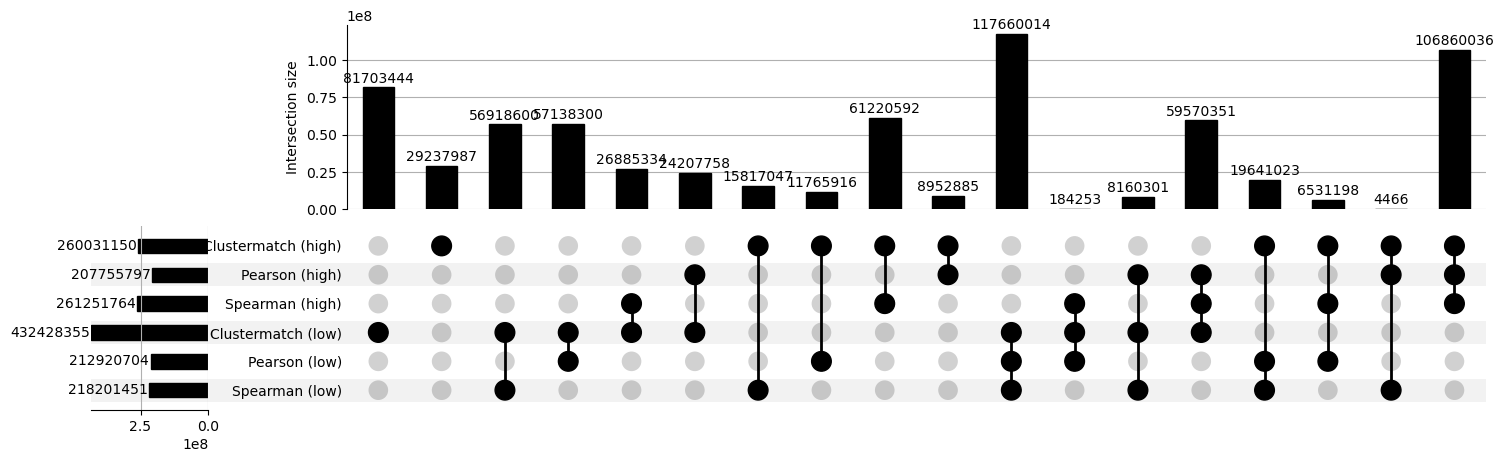

In [30]:
fig = plt.figure(figsize=(18, 5))

g = plot(
    gene_pairs_by_cats,
    show_counts=True,
    sort_categories_by=None,
    element_size=None,
    fig=fig,
)

In [33]:
plt.savefig(
    OUTPUT_DIR / f"{OUTPUT_FIGURE_NAME}_full.svg",
    bbox_inches="tight",
    facecolor="white",
)

<Figure size 640x480 with 0 Axes>

## Sort by categories of subsets

In [34]:
df_r_data = df_plot

In [35]:
df_r_data.shape

(692459505, 9)

In [36]:
gene_pairs_by_cats = from_indicators(categories, data=df_r_data)

In [37]:
gene_pairs_by_cats

Pearson (high)  \
Spearman (low) Pearson (low) Clustermatch (low) Spearman (high) Pearson (high) Clustermatch (high)                   
False          False         False              True            True           True                           True   
               True          False              True            False          True                          False   
                                                                               True                          False   
               False         False              True            True           True                           True   
                                                                               True                           True   
...                                                                                                            ...   
                             True               False           False          False                         False   
                             False              True            True           True                           True   
True           False         False              False           False          True                          False   
                             True               False           False          False                         False   
                             False              False           False          True                          False   

                                                                                                    Pearson (low)  \
Spearman (low) Pearson (low) Clustermatch (low) Spearman (high) Pearson (high) Clustermatch (high)                  
False          False         False              True            True           True                         False   
               True          False              True            False          True                          True   
                                                                               True                          True   
               False         False              True            True           True                         False   
                                                                               True                         False   
...                                                                                                           ...   
                             True               False           False          False                        False   
                             False              True            True           True                         False   
True           False         False              False           False          True                         False   
                             True               False           False          False                        False   
                             False              False           False          True                         False   

                                                                                                    Spearman (high)  \
Spearman (low) Pearson (low) Clustermatch (low) Spearman (high) Pearson (high) Clustermatch (high)                    
False          False         False              True            True           True                            True   
               True          False              True            False          True                            True   
                                                                               True                            True   
               False         False              True            True           True                            True   
                                                                               True                            True   
...                                                                                                             ...   
                             True               False           False          False       

In [38]:
gene_pairs_by_cats = gene_pairs_by_cats.sort_index()

In [39]:
_tmp_index = gene_pairs_by_cats.index.unique().to_frame(False)
display(_tmp_index)

,Spearman (low),Pearson (low),Clustermatch (low),Spearman (high),Pearson (high),Clustermatch (high)
0,False,False,False,False,False,True
1,False,False,False,False,True,True
2,False,False,False,True,False,True
3,False,False,False,True,True,True
4,False,False,True,False,False,False
5,False,False,True,False,True,False
6,False,False,True,True,False,False
7,False,False,True,True,True,False
8,False,True,False,False,False,True
9,False,True,False,True,False,True


In [40]:
_tmp_index[_tmp_index.sum(axis=1) == 3]

,Spearman (low),Pearson (low),Clustermatch (low),Spearman (high),Pearson (high),Clustermatch (high)
3,False,False,False,True,True,True
7,False,False,True,True,True,False
9,False,True,False,True,False,True
11,False,True,True,True,False,False
13,True,False,False,False,True,True
15,True,False,True,False,True,False
16,True,True,False,False,False,True
17,True,True,True,False,False,False


In [41]:
_tmp_index.apply(lambda x: x[0:3].sum() == 0, axis=1)

0      True
1      True
2      True
3      True
4     False
5     False
6     False
7     False
8     False
9     False
10    False
11    False
12    False
13    False
14    False
15    False
16    False
17    False
dtype: bool

In [42]:
# agreements on top
_tmp_index.loc[
    _tmp_index[
        _tmp_index.apply(lambda x: x.sum() > 1, axis=1)
        & _tmp_index.apply(lambda x: x[0:3].sum() == 0, axis=1)
        & _tmp_index.apply(lambda x: 3 > x[3:].sum() > 1, axis=1)
    ].index
].apply(tuple, axis=1).to_numpy()

array([(False, False, False, False, True, True),
       (False, False, False, True, False, True)], dtype=object)

In [43]:
# agreements on bottom
_tmp_index.loc[
    _tmp_index[
        _tmp_index.apply(lambda x: x.sum() > 1, axis=1)
        & _tmp_index.apply(lambda x: 3 > x[0:3].sum() > 1, axis=1)
        & _tmp_index.apply(lambda x: x[3:].sum() == 0, axis=1)
    ].index
].apply(tuple, axis=1).to_numpy()

array([(False, True, True, False, False, False),
       (True, False, True, False, False, False)], dtype=object)

In [44]:
# diagreements
_tmp_index.loc[
    _tmp_index[
        _tmp_index.apply(lambda x: x.sum() > 1, axis=1)
        & _tmp_index.apply(lambda x: x[0:3].sum() > 0, axis=1)
        & _tmp_index.apply(lambda x: x[3:].sum() > 0, axis=1)
    ].index
].apply(tuple, axis=1).to_numpy()

array([(False, False, True, False, True, False),
       (False, False, True, True, False, False),
       (False, False, True, True, True, False),
       (False, True, False, False, False, True),
       (False, True, False, True, False, True),
       (False, True, True, True, False, False),
       (True, False, False, False, False, True),
       (True, False, False, False, True, True),
       (True, False, True, False, True, False),
       (True, True, False, False, False, True)], dtype=object)

In [46]:
# order subsets
gene_pairs_by_cats = gene_pairs_by_cats.loc[
    [
        (False, False, False, True, True, True),
        # agreements on top
        (False, False, False, False, True, True),
        (False, False, False, True, False, True),
        (False, False, False, True, True, False),
        # agreements on bottom
        (False, True, True, False, False, False),
        (True, False, True, False, False, False),
        (True, True, False, False, False, False),
        # full agreements on low:
        (True, True, True, False, False, False),
        # diagreements
        #   ccc
        (False, True, False, False, False, True),
        (True, False, False, False, False, True),
        (True, True, False, False, False, True),
        (True, False, False, False, True, True),
        (False, True, False, True, False, True),
        #   pearson
        (False, False, True, False, True, False),
        (True, False, True, False, True, False),
        (True, False, False, False, True, False),
        (False, False, True, True, True, False),
        #   spearman
        (False, False, True, True, False, False),
        (False, True, True, True, False, False),
        (False, True, False, True, False, False),
    ]
]

In [47]:
gene_pairs_by_cats.head()

Pearson (high)  \
Spearman (low) Pearson (low) Clustermatch (low) Spearman (high) Pearson (high) Clustermatch (high)                   
False          False         False              True            True           True                           True   
                                                                               True                           True   
                                                                               True                           True   
                                                                               True                           True   
                                                                               True                           True   

                                                                                                    Pearson (low)  \
Spearman (low) Pearson (low) Clustermatch (low) Spearman (high) Pearson (high) Clustermatch (high)                  
False          False         False              True            True           True                         False   
                                                                               True                         False   
                                                                               True                         False   
                                                                               True                         False   
                                                                               True                         False   

                                                                                                    Spearman (high)  \
Spearman (low) Pearson (low) Clustermatch (low) Spearman (high) Pearson (high) Clustermatch (high)                    
False          False         False              True            True           True                            True   
                                                                               True                            True   
                                                                               True                            True   
                                                                               True                            True   
                                                                               True                            True   

                                                                                                    Spearman (low)  \
Spearman (low) Pearson (low) Clustermatch (low) Spearman (high) Pearson (high) Clustermatch (high)                   
False          False         False              True            True           True                          False   
                                                                               True                          False   
                                                                               True                          False   
                                                                               True                          False   
                                                                               True                          False   

                                                                                                    Clustermatch (high)  \
Spearman (low) Pearson (low) Clustermatch (low) Spearman (high) Pearson (high) Clustermatch (high)                        
False          False         False              True            True           True                                True   
                                                                               True                                True   
                                                                               True                                True   
                                                                               True                                True   
                                                      

In [48]:
gene_pairs_by_cats = gene_pairs_by_cats.rename(
    columns={
        "Clustermatch (high)": "CCC (high)",
        "Clustermatch (low)": "CCC (low)",
    }
)

gene_pairs_by_cats.index.set_names(
    {
        "Clustermatch (high)": "CCC (high)",
        "Clustermatch (low)": "CCC (low)",
    },
    inplace=True,
)

/home/haoyu/miniforge3/envs/ccc-gpu/lib/python3.10/site-packages/upsetplot/plotting.py:795: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  styles["linewidth"].fillna(1, inplace=True)
/home/haoyu/miniforge3/envs/ccc-gpu/lib/python3.10/site-packages/upsetplot/plotting.py:796: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are sett

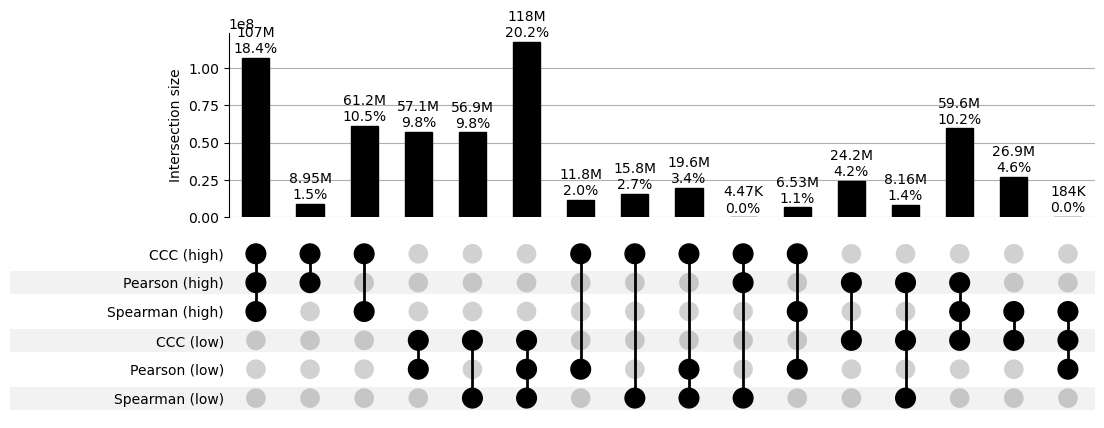

In [49]:
fig = plt.figure(figsize=(14, 5))

# g = plot(
g = MyUpSet(
    gene_pairs_by_cats,
    show_counts=True,
    sort_categories_by=None,
    sort_by=None,
    show_percentages=True,
    # min_subset_size=2,
    element_size=None,
    # fig=fig,
).plot(fig)

g["totals"].remove()  # set_visible(False)

# display(fig.get_size_inches())
# fig.set_size_inches(12, 5)

plt.savefig(
    OUTPUT_DIR / f"{OUTPUT_FIGURE_NAME}_trimmed.svg",
    bbox_inches="tight",
    facecolor="white",
)

# plt.margins(x=-0.4)

This plot has the sets that represent agreements on the left, and disagreements on the right.

The plot shown here is **not the final one for the manuscript**:

1. Open the main output svg file (`upsetplot-main.svg`)
1. Include the file generated here (`upsetplot.svg`)
1. Rearrange the `1e6` at the top, which is overlapping other numbers.
1. Add the triangles (red and green). For this I need to move the category names at the left to make space.
1. Add a rectangle and clip it to remove the extra space on the left
1. Add the "Agreements" and "Disagreements" labels below.
1. Automatically resize page to drawing.
1. Add a rectangle that covers the entire drawing with white background. And send it to the background.

# Save groups of gene pairs in each subset

In [50]:
display(df_plot.shape)
display(df_plot.head())

(692459505, 9)

Pearson (high)  Pearson (low)  \
ENSG00000211592.8  ENSG00000211596.3            True          False   
ENSG00000116218.12 ENSG00000211596.3           False           True   
                   ENSG00000211592.8           False           True   
ENSG00000211893.3  ENSG00000211596.3            True          False   
                   ENSG00000211592.8            True          False   

                                      Spearman (high)  Spearman (low)  \
ENSG00000211592.8  ENSG00000211596.3             True           False   
ENSG00000116218.12 ENSG00000211596.3             True           False   
                   ENSG00000211592.8             True           False   
ENSG00000211893.3  ENSG00000211596.3             True           False   
                   ENSG00000211592.8             True           False   

                                      Clustermatch (high)  Clustermatch (low)  \
ENSG00000211592.8  ENSG00000211596.3                 True               False   
ENSG00000116218.12 ENSG00000211596.3                 True               False   
                   ENSG00000211592.8                 True               False   
ENSG00000211893.3  ENSG00000211596.3                 True               False   
                   ENSG00000211592.8                 True               False   

                                      ccc   pearson  spearman  
ENSG00000211592.8  ENSG00000211596.3  1.0  1.000000  1.000000  
ENSG00000116218.12 ENSG00000211596.3  1.0  0.130737  0.799805  
                   ENSG00000211592.8  1.0  0.145020  0.799805  
ENSG00000211893.3  ENSG00000211596.3  1.0  0.951172  1.000000  
                   ENSG00000211592.8  1.0  0.955566  1.000000

In [51]:
output_file = (
    OUTPUT_DIR
    / OUTPUT_GENE_PAIR_INTERSECTIONS_NAME
)
display(output_file)

PosixPath('/mnt/data/proj_data/ccc-gpu/results/gene_pair_intersections/gene_pair_intersections-gtex_v8-kidney_medulla-var_pc_log2.pkl')

In [52]:
df_plot.to_pickle(output_file)